In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
cmap = mpl.cm.get_cmap('viridis')

import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import *
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from utils.model import hill_activation, hill_activation_single, hill_activation_and

In [43]:
folder = 'datasets/cleansed'
subfolder = 'promoter-permutation'
hill_params = {
    'pbad': [0.52, -0.06, 0.15, -2.06],
    'pcin': [-0.32, 0.91, 0.29, -3.11],
    'psalttc': [-0.46, 1.76, 0.29, -1.71]
}
pro_ind = {
    'ara': 'pbad',
    'ohc14': 'pcin',
    'sal': 'psalttc'
}
ind_pro = {
    'pbad': 'ara',
    'pcin': 'ohc14',
    'psalttc': 'sal'
}

In [3]:
def fit_model(gates, model_name='GP', y_label='fluo', scale='log'):
    
    if scale=='log':
        gates_ = [np.log10(g) for g in gates]
    else:
        gates_ = gates.copy()
    
    models = []
    for gate in gates_:
        X = gate.drop(y_label, axis=1)
        y = gate[y_label]
        if model_name=='GP':
            model = gp.GaussianProcessRegressor()
        elif model_name=='GP+Noise':
            model = gp.GaussianProcessRegressor(kernel=WhiteKernel() + RBF(1, "fixed"))
        elif model_name=='NN':
            model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(300, 300))
        
        model.fit(X, y)
        models.append(model)
        
    return models

In [63]:
def plot_decompose(model, data, title='E20', model_name='NN', scale='log', show_interval=False):
    
    if scale=='log':
        data = np.log10(data)
    
    #setup bounds for model
    inducers_lbl = data.columns[:2].tolist()
    i1 = data[inducers_lbl[0]].unique()
    i2 = data[inducers_lbl[1]].unique()
    #if data is already in log-scale, then the model is generated in linear-scale
    ind1 = np.linspace(i1.min(), i1.max(), 1000)
    ind2 = np.linspace(i2.min(), i2.max(), 1000)
    
    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*4))
    ax = axs.ravel()

    fixed = inducers_lbl[0]
    varied = inducers_lbl[1]
    
    #prediction
    pred_data = pd.DataFrame(itertools.product(i1, ind2), columns=inducers_lbl)
    if show_interval:
        pred_data['fluo'], pred_data['fluo_std'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['fluo'] = model.predict(pred_data)
        
    num_col_palette = len(data[fixed].unique())-1
    for x, i in enumerate(data[fixed].unique()):
        
        act = data[data[fixed]==i]
        ax[0].scatter(act[varied], act['fluo'], color=cmap(x/num_col_palette))
        pred = pred_data[pred_data[fixed]==i]
        ax[0].plot(pred[varied], pred['fluo'], color=cmap(x/num_col_palette), label=np.round(i, 2))
        if show_interval:
            ax[0].fill_between(
                pred[varied],
                pred['fluo'] - 1.96 * pred['fluo_std'],
                pred['fluo'] + 1.96 * pred['fluo_std'],
                alpha=0.2,
                color=cmap(x/num_col_palette)
            )
    ax[0].set_xlabel('{} (log RPU)'.format(pro_ind[varied]))
    ax[0].set_ylabel('P20 (log RPU)')
    ax[0].legend(title='{} (log RPU)'.format(pro_ind[fixed]), loc='center', bbox_to_anchor=(0.5, 1.15), ncol=int(len(i2)/2))

    fixed = inducers_lbl[1]
    varied = inducers_lbl[0]
    
    pred_data = pd.DataFrame(itertools.product(ind1, i2), columns=inducers_lbl)
    if show_interval:
        pred_data['fluo'], pred_data['fluo_std'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['fluo'] = model.predict(pred_data)
    
    num_col_palette = len(data[fixed].unique())-1
    for x, i in enumerate(data[fixed].unique()):
        
        act = data[data[fixed]==i]
        ax[1].scatter(act[varied], act['fluo'], color=cmap(x/num_col_palette))
        
        pred = pred_data[pred_data[fixed]==i]
        ax[1].plot(pred[varied], pred['fluo'], color=cmap(x/num_col_palette), label=np.round(i, 4))
        if show_interval:
            ax[1].fill_between(
                pred[varied],
                pred['fluo'] - 1.96 * pred['fluo_std'],
                pred['fluo'] + 1.96 * pred['fluo_std'],
                alpha=0.2,
                color=cmap(x/num_col_palette)
            )
    ax[1].set_xlabel('{} (log RPU)'.format(pro_ind[varied]))
    ax[1].set_ylabel('P20 (log RPU)')
    ax[1].legend(title='{} (log RPU)'.format(pro_ind[fixed]), loc='center', bbox_to_anchor=(0.5, 1.15), ncol=int(len(i2)/2))

    plt.suptitle('{} ({}-{})'.format(title, *inducers_lbl))
    plt.tight_layout()
    sns.despine()

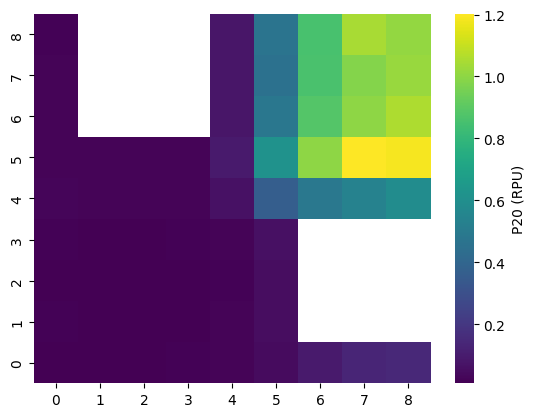

In [104]:
filename = 'PBAD-PCin-E20'
e1 = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
e2 = pd.read_csv('{}/{}/{}-2.csv'.format(folder, subfolder, filename))
ind_lbl = e1.columns[:2].tolist()
e = pd.concat([e1, e2], axis=0).sort_values(ind_lbl).reset_index(drop=True)
sns.heatmap(e.pivot_table(index=ind_lbl[1], columns=ind_lbl[0]).values, cmap='viridis', cbar_kws={'label': 'P20 (RPU)'}).invert_yaxis()
plt.show()

#### Function of promoter's activities

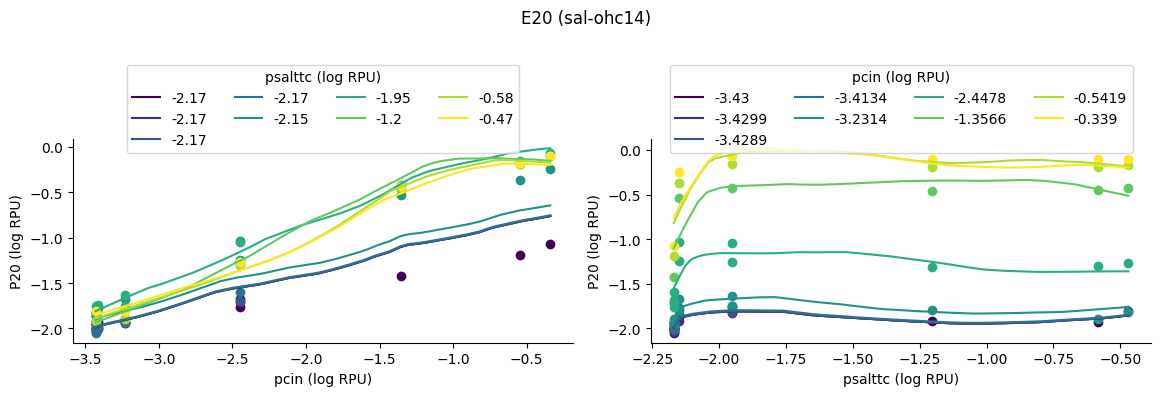

In [124]:
filename = 'PSalTTC-PCin-E20'
e1 = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
e2 = pd.read_csv('{}/{}/{}-2.csv'.format(folder, subfolder, filename))
ind_lbl = e1.columns[:2].tolist()
e = pd.concat([e1, e2], axis=0).sort_values(ind_lbl).reset_index(drop=True)
model_name = 'NN'
promoter_activity = True
data = e.copy().dropna()
if not promoter_activity:
    replace_zero = data[ind_lbl[0]].unique()[1]/4, data[ind_lbl[1]].unique()[1]/4
    data[ind_lbl[0]] = data[ind_lbl[0]].apply(lambda x: replace_zero[0] if x==0 else x)
    data[ind_lbl[1]] = data[ind_lbl[1]].apply(lambda x: replace_zero[1] if x==0 else x)
else:
    data[ind_lbl[0]] = hill_activation_single(data[ind_lbl[0]], *hill_params[pro_ind[ind_lbl[0]]])
    data[ind_lbl[1]] = hill_activation_single(data[ind_lbl[1]], *hill_params[pro_ind[ind_lbl[1]]])

models = fit_model([data], model_name=model_name)
plot_decompose(models[0], data, model_name=model_name, show_interval=False)

Prediction

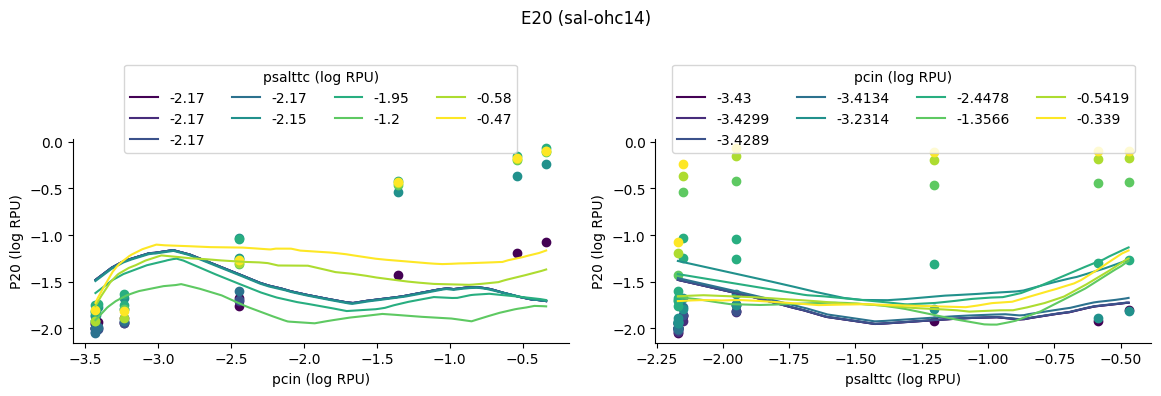

In [83]:
filename = 'PSalTTC-PCin-E20'
e1 = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
e2 = pd.read_csv('{}/{}/{}-2.csv'.format(folder, subfolder, filename))
ind_lbl = e1.columns[:2].tolist()
e = pd.concat([e1, e2], axis=0).sort_values(ind_lbl).reset_index(drop=True)

promoter_activity = True
data = e.copy().dropna()
if not promoter_activity:
    replace_zero = data[ind_lbl[0]].unique()[1]/4, data[ind_lbl[1]].unique()[1]/4
    data[ind_lbl[0]] = data[ind_lbl[0]].apply(lambda x: replace_zero[0] if x==0 else x)
    data[ind_lbl[1]] = data[ind_lbl[1]].apply(lambda x: replace_zero[1] if x==0 else x)
else:
    data[ind_lbl[0]] = hill_activation_single(data[ind_lbl[0]], *hill_params[pro_ind[ind_lbl[0]]])
    data[ind_lbl[1]] = hill_activation_single(data[ind_lbl[1]], *hill_params[pro_ind[ind_lbl[1]]])

plot_decompose(models[0], data, model_name=model_name, show_interval=False)

#### Function of inducer's concentrations

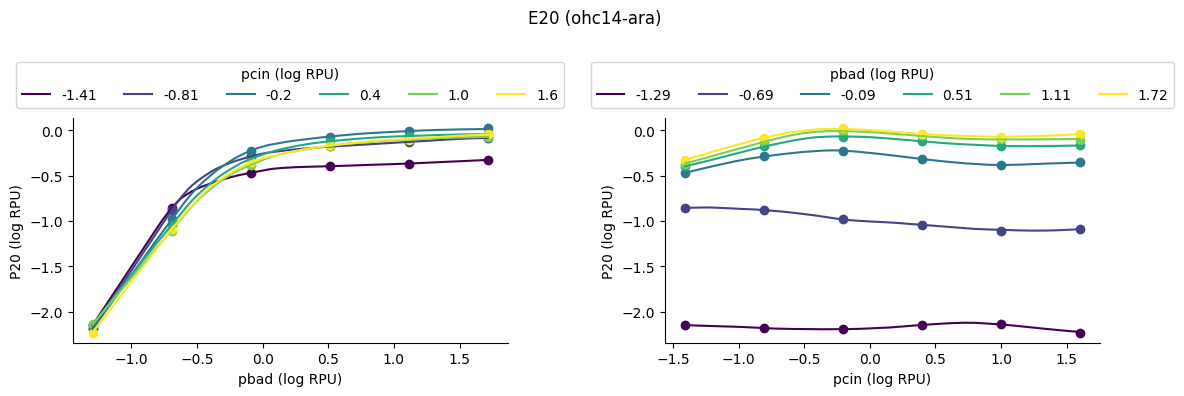

In [24]:
filename = 'PCin-PBAD-E20'
model_name = 'NN'
gates = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
ind_cols = gates.columns[:2].tolist()
gate_cols = gates.columns[2:].tolist()
gates_list = [gates[ind_cols+[g]].rename(columns={g:'fluo'}) for g in gate_cols]
data = gates_list[0]
replace_zero = data[ind_cols[0]].unique()[1]/4, data[ind_cols[1]].unique()[1]/4
data[ind_cols[0]] = data[ind_cols[0]].apply(lambda x: replace_zero[0] if x==0 else x)
data[ind_cols[1]] = data[ind_cols[1]].apply(lambda x: replace_zero[1] if x==0 else x)

models = fit_model([data], model_name=model_name)
plot_decompose(models[0], data, model_name=model_name, show_interval=False)

#### 2D Visualization

6it [00:53,  8.89s/it]


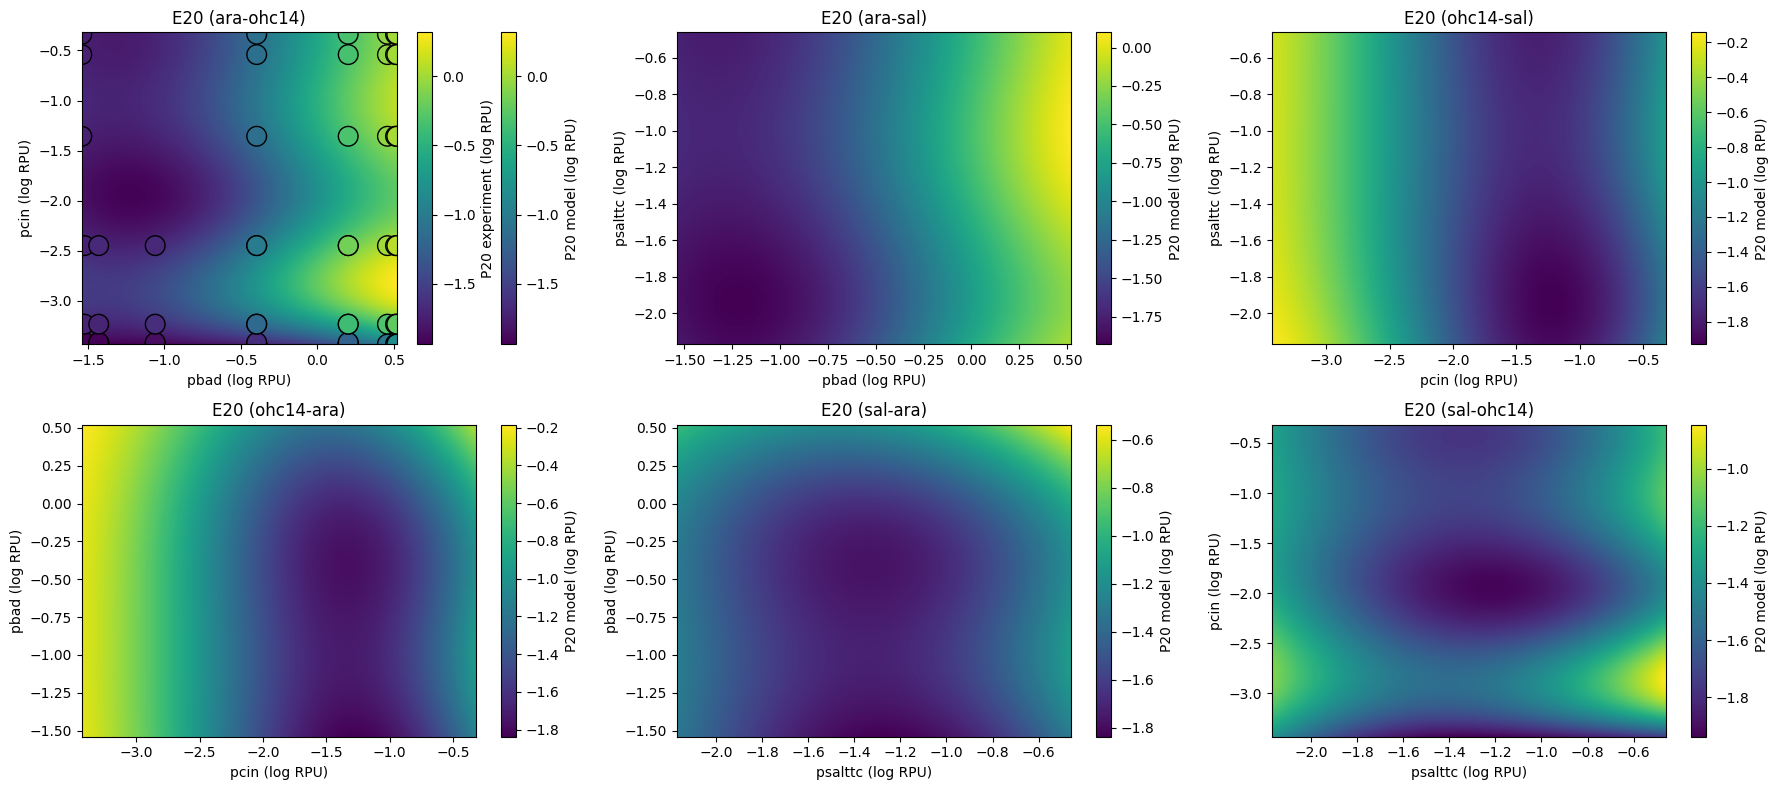

In [121]:
def plot_1d(model, data, title='E20', model_name='NN', scale='log'):
    
    act_inducers = data.columns[:2].tolist()
    ind_min_max = {
        'ara': np.log10(hill_activation_single(np.array([0, 208]), *hill_params['pbad'])),
        'ohc14': np.log10(hill_activation_single(np.array([0, 160]), *hill_params['pcin'])),
        'sal': np.log10(hill_activation_single(np.array([0, 1600]), *hill_params['psalttc']))
    }
    ind_combo = [['ara', 'ohc14'], ['ara', 'sal'], ['ohc14', 'sal'],
                ['ohc14', 'ara'], ['sal', 'ara'], ['sal', 'ohc14']]
    
    if scale=='log':
        data = np.log10(data)
        
    row, col = 2, 3
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*4))
    ax = axs.ravel()
    
    #setup bounds for model
    #inducers_lbl = data.columns[:2].tolist()
    for i, inducers_lbl in tqdm(enumerate(ind_combo)):
        i1 = ind_min_max[inducers_lbl[0]]
        i2 = ind_min_max[inducers_lbl[1]]
        
        #if data is already in log-scale, then the model is generated in linear-scale
        ind1 = np.linspace(i1.min(), i1.max(), 1000)
        ind2 = np.linspace(i2.min(), i2.max(), 1000)

        inducers = [ind1, ind2]
        pred_data = pd.DataFrame(itertools.product(*inducers))
        pred_data.columns = inducers_lbl
        pred_data['prediction'] = model.predict(pred_data)

        p1 = ax[i].pcolormesh(pred_data[inducers_lbl[0]].unique(), pred_data[inducers_lbl[1]].unique(),
                            pred_data.pivot_table(index=inducers_lbl[1], columns=inducers_lbl[0]).values, cmap='viridis',
                            vmin=pred_data['prediction'].min(), vmax=pred_data['prediction'].max())
        cbar1 = plt.colorbar(p1, ax=ax[i])
        cbar1.set_label('P20 model (log RPU)')
        
        if inducers_lbl==act_inducers:
            p2 = ax[i].scatter(data[inducers_lbl[0]], data[inducers_lbl[1]],
                             c=data['fluo'], edgecolors='black', s=200, cmap='viridis',
                             vmin=pred_data['prediction'].min(), vmax=pred_data['prediction'].max()) 
            cbar2 = plt.colorbar(p2, ax=ax[i])
            cbar2.set_label('P20 experiment (log RPU)')

        ax[i].set_xlabel('{} (log RPU)'.format(pro_ind[inducers_lbl[0]]))
        ax[i].set_ylabel('{} (log RPU)'.format(pro_ind[inducers_lbl[1]]))
        ax[i].set_title('{} ({}-{})'.format(title, *inducers_lbl))
        
    plt.tight_layout()
    
plot_1d(models[0], data)

6it [04:29, 44.86s/it]


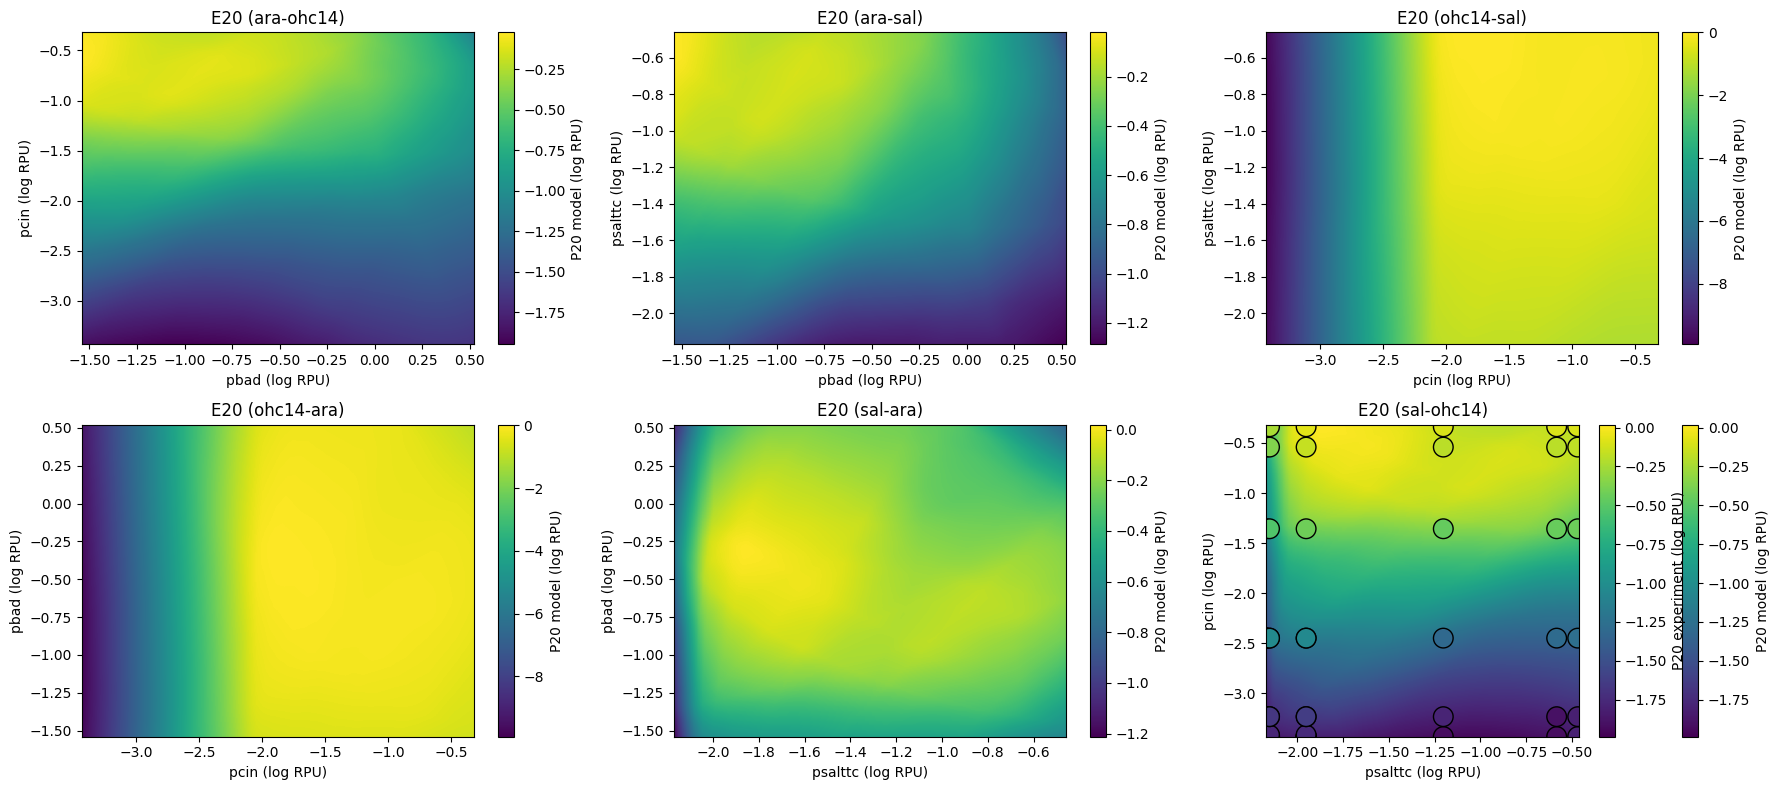

In [125]:
plot_1d(models[0], data)